In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

sys.path.append('../src')
from models import VanillaAutoEncoder, VariationalAutoEncoder

import umap
import umap.plot
import hdbscan
import sklearn.datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


from sklearn.model_selection import train_test_split

/Applications/anaconda3/envs/maldi_autoencoder/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualise latent space

In [2]:
input_shape = 18000
latent_shape = 8

m_state_dict = torch.load('../experiments/results/latent_learning/num_dist_4/pae_variational_epoch_20.pt', map_location=torch.device('cpu'))
model_new = VariationalAutoEncoder(input_shape, latent_shape)

model_new.load_state_dict(m_state_dict)

<All keys matched successfully>

In [3]:
# Loading DRIAMS and Alfred data

pae_driams = pd.read_csv('/Volumes/T7/MALDI_TOF/DRIAMS/pae_driams.csv')
pae_alfred_whole = pd.read_csv('/Volumes/T7/MALDI_TOF/DRIAMS/pae_alfred.csv')

alfred_train_ids = pd.read_csv("/Users/Andy/Dropbox/git_repos/Alfred_data/MALDI-TOF/alfred_train_ids.txt", header=None).values.flatten()

alfred_test_ids = pd.read_csv("/Users/Andy/Dropbox/git_repos/Alfred_data/MALDI-TOF/alfred_test_ids.txt", header=None).values.flatten()

pae_alfred = pae_alfred_whole.copy()[pae_alfred_whole['id'].isin(alfred_train_ids)]
pae_alfred_test = pae_alfred_whole.copy()[pae_alfred_whole['id'].isin(alfred_test_ids)]

alfred_antimicrobials = list(pae_alfred.columns[18001:].values)

In [4]:
antimicrobials = {"meropenem": "Meropenem", 
                  "amikacin": "Amikacin", 
                  "aztreonam": "Aztreonam", 
                  "ciprofloxacin": "Ciprofloxacin",
                  "piperacillin_tazobactam": "Piperacillin/tazobactam", 
                  "ceftolozane_tazobactam": "Ceftolozane/tazobactam",
                  "colistin": "Colistin", 
                  "tobramycin": "Tobramycin", 
                  "ceftazidime": "Ceftazidime",
                  "ceftazidime_avibactam": "Ceftazidime/avibactam", 
                  "imipenem": "Imipenem"}

In [5]:
max_intensity=0.009055 # Normalizing factor
X_cols = [str(2000 + i) for i in range(18000)]
alfred_X = torch.tensor(pae_alfred[X_cols].to_numpy() / max_intensity)
alfred_X_test = torch.tensor(pae_alfred_test[X_cols].to_numpy() / max_intensity)


In [6]:
with torch.no_grad():
    Z, mu, logvar = model_new.encoder(alfred_X.float())
    Z_test, _, _ = model_new.encoder(alfred_X_test.float())
mapper = umap.UMAP(n_neighbors=20, random_state=333).fit(Z)  # Initial seed=333

umap_values = mapper.transform(Z)
umap_alfred_test_values = mapper.transform(Z_test)

In [26]:
# Extract layer for analysis
Z_train_df = pd.DataFrame(Z)
Z_train_df['id'] = alfred_train_ids

Z_test_df = pd.DataFrame(Z_test)
Z_test_df['id'] = alfred_test_ids

Z_whole_df = pd.concat([Z_train_df, Z_test_df], 
                       axis=0, 
                       ignore_index=True)

Z_whole_df.columns = [str(col) for col in Z_whole_df.columns]


normalising_factor = Z_whole_df[[str(i) for i in range(8)]].max().max()

Z_whole_df[[str(i) for i in range(8)]] = Z_whole_df[[str(i) for i in range(8)]]/normalising_factor

Z_whole_df.to_csv("outputs/alfred_latent_4_gaussian_distributions.csv", index=False)

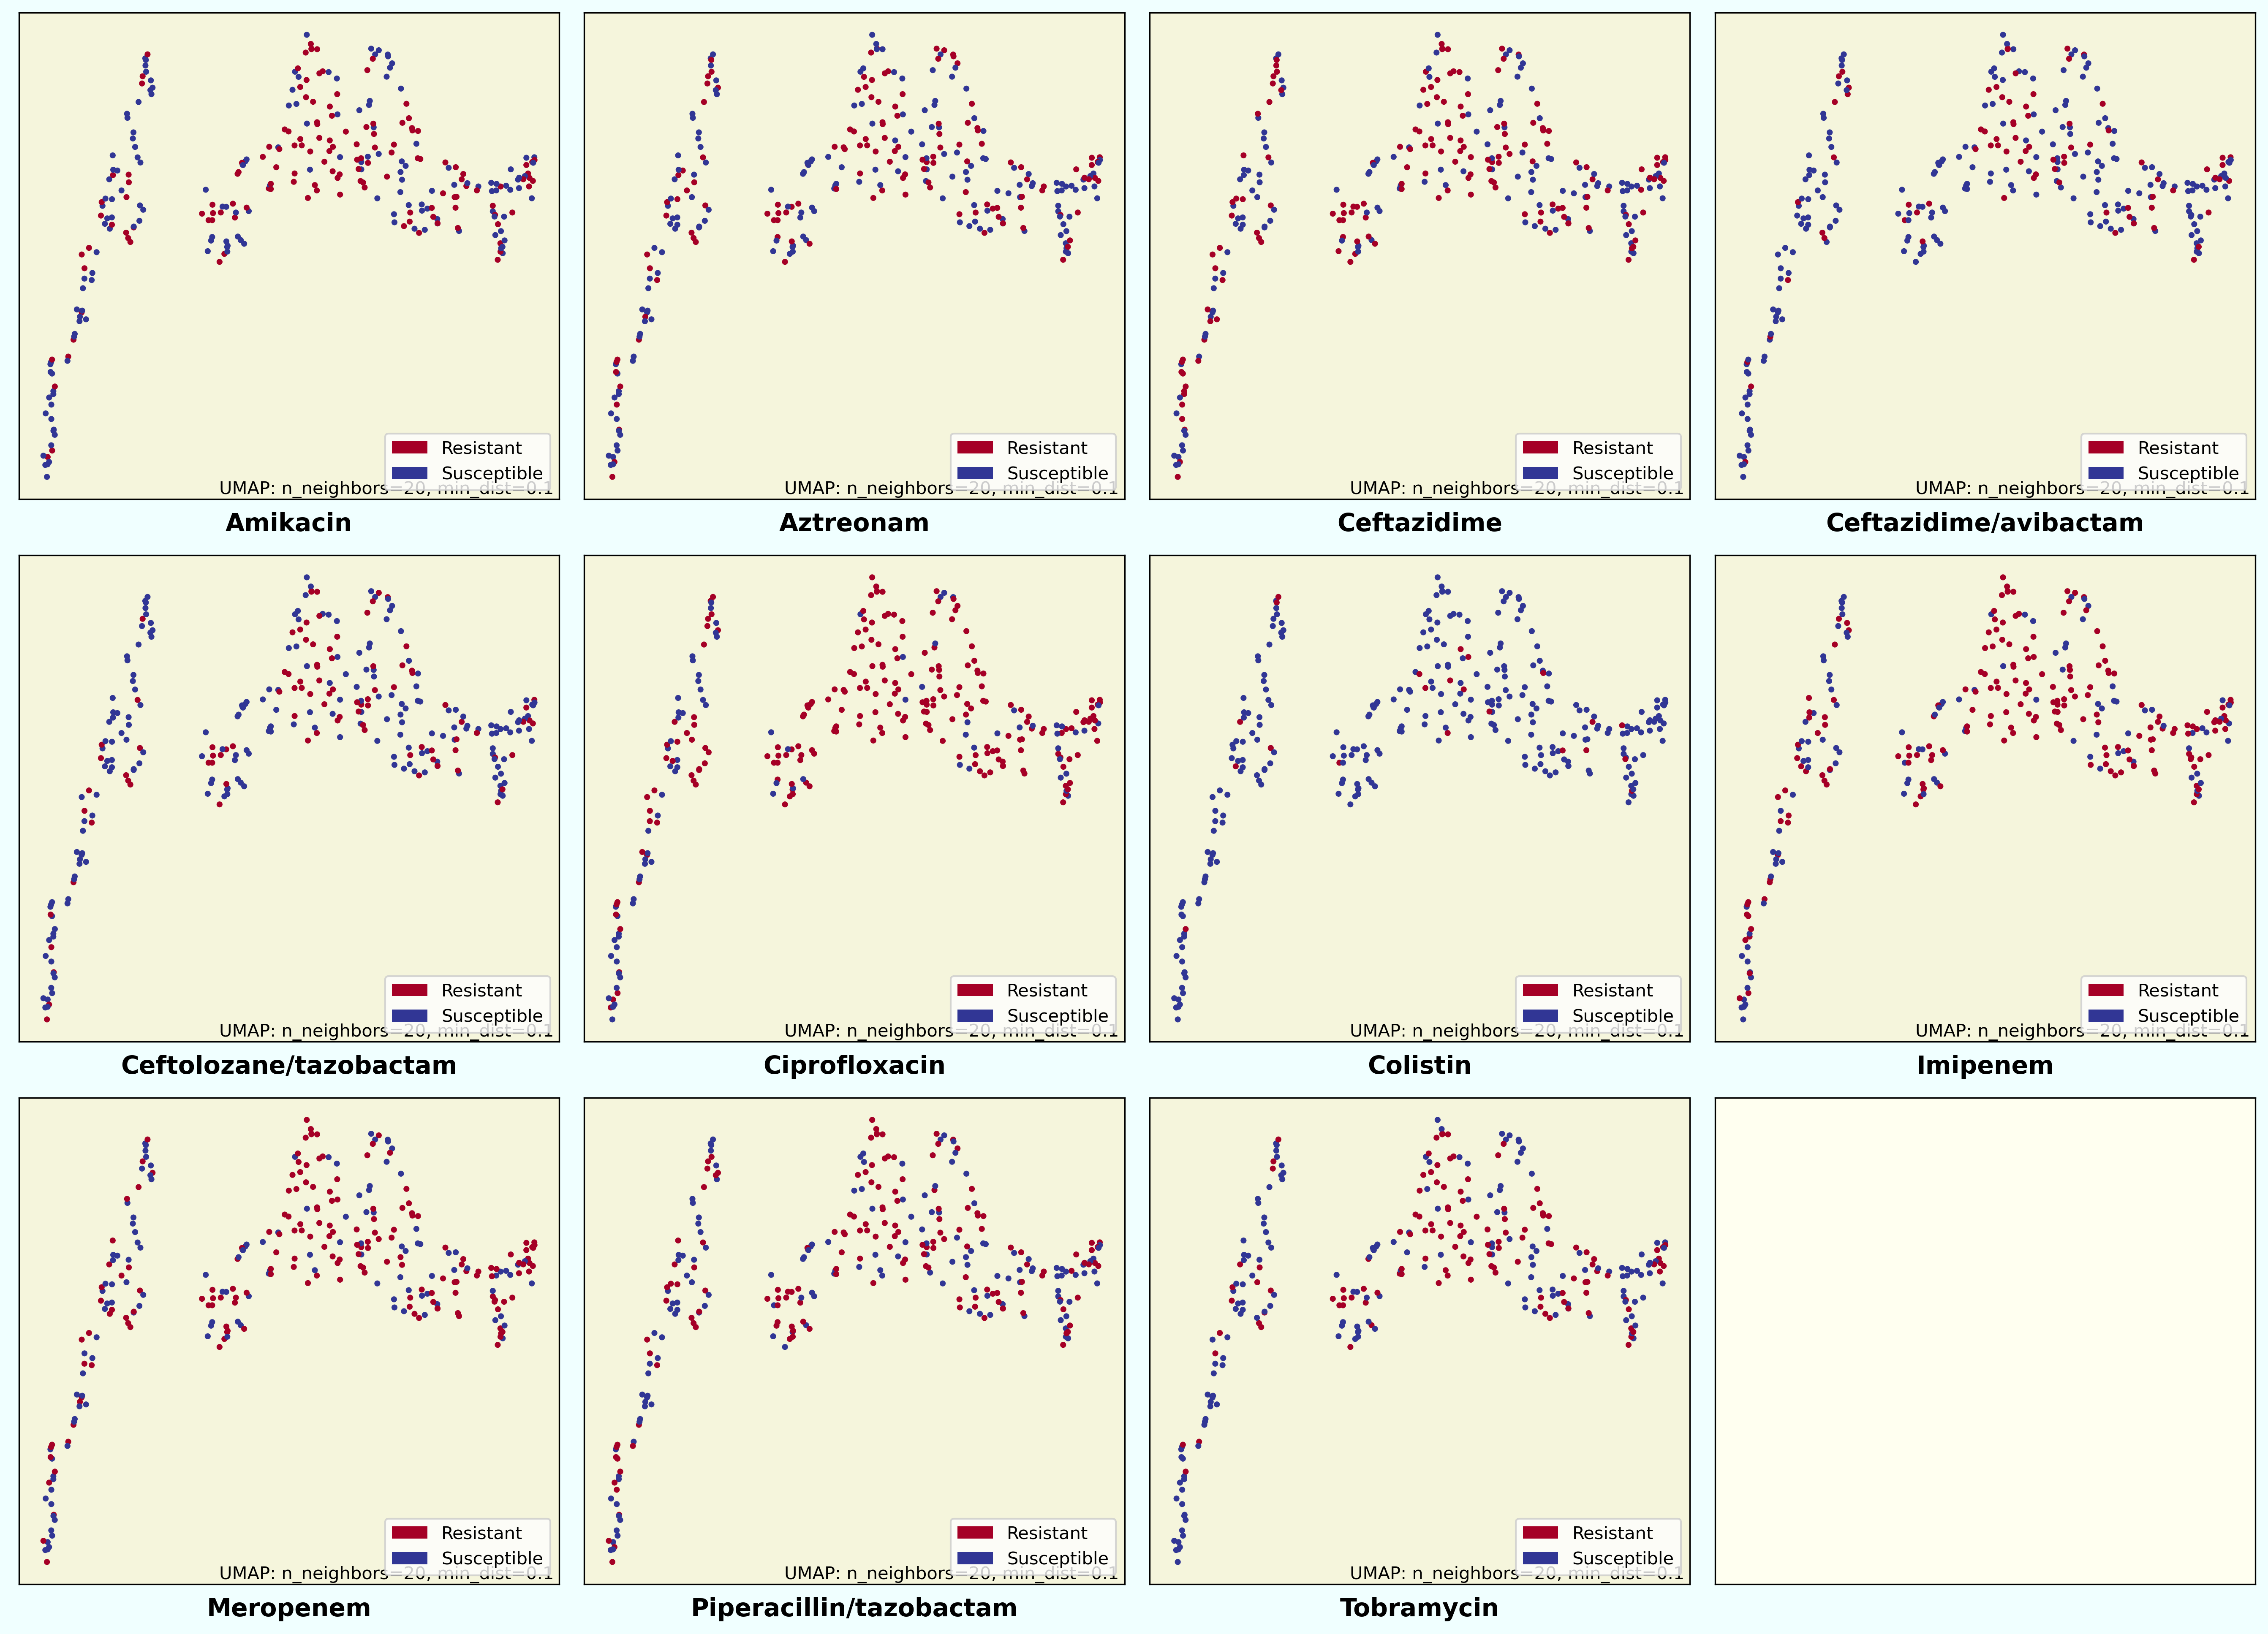

In [7]:
counter = 0
nrows = 3
ncols = 4

fig, ax = umap.plot.plt.subplots(nrows, ncols, figsize=(18,13), dpi=300)

for row_idx in range(nrows):
    for col_idx in range(ncols):
        tmp_ax = ax[row_idx, col_idx]
        if counter == len(alfred_antimicrobials):
            tmp_ax.set_facecolor('ivory')
            tmp_ax.set(xlabel=None, ylabel=None)
            tmp_ax.set_xticks([])
            tmp_ax.set_yticks([])
            break
        else:
            antimicrobial = sorted(alfred_antimicrobials)[counter]
            label = pae_alfred[antimicrobial].values
            to_ast_label  = lambda t: 'Susceptible' if t == 0 else "Resistant"
            to_ast_func = np.vectorize(to_ast_label)
            label = to_ast_func(label)
            umap.plot.points(mapper, 
                             labels=label,
                             color_key_cmap='RdYlBu',
                             background='beige',
                             ax=tmp_ax)
            rect1 = patches.Rectangle((4.7, 7.3), 7, 2.5, linewidth=1,  edgecolor='orangered', facecolor='none')
            # rect1 = patches.Rectangle((-5.54, 0.1), 3, 4.8, linewidth=1,  edgecolor='yellow', facecolor='none')
            # rect2 = patches.Rectangle((11.5, 3), 3, 6, linewidth=1,  edgecolor='orange', facecolor='none')
            # tmp_ax.add_patch(rect1)
            # tmp_ax.add_patch(rect2)
            tmp_ax.set_xlabel(antimicrobials[antimicrobial], 
                              fontweight='bold', 
                              fontsize=14)
            # tmp_ax.plot(X_sample[:40], 
            #             Y_sample[:40], 
            #             'gs')
            # tmp_ax.plot(umap_alfred_test_values[:, 0], 
            #             umap_alfred_test_values[:, 1], 
            #             'gs')

        counter += 1

fig.patch.set_facecolor('azure')
plt.tight_layout()

# Clustering algorithm

In [38]:
# Function for determine optimal number of clusters

from yellowbrick.cluster import KElbowVisualizer

def determine_optimal_k(train_set, 
                        test_set=None, 
                        metric='distortion', 
                        seed=222):
    model = KMeans(random_state=seed)
    visualizer = KElbowVisualizer(model,
                                  k=20,
                                  timings=False,
                                  metric=metric)
    visualizer.fit(train_set)
    print(f"Elbow value: {visualizer.elbow_value_}")
    visualizer.ax.set_xticks(np.arange(0, 21, 1))
    visualizer.ax.set_xlabel("Number of clusters")
    visualizer.show()
    plt.show()

    # training with optimal K
    kmeans = KMeans(n_clusters=visualizer.elbow_value_, 
                    random_state=seed).fit(train_set)
    test_labels = kmeans.predict(test_set)

    return kmeans.labels_, test_labels
    


Elbow value: 8


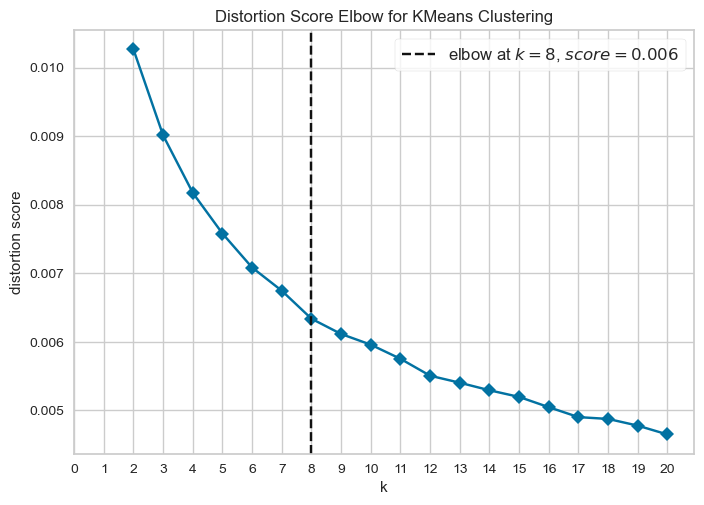

In [42]:
# Clustering for raw input data

train_raw, test_raw = determine_optimal_k(pae_alfred[X_cols].to_numpy(),
                                          pae_alfred_test[X_cols].to_numpy())


In [74]:
train_raw_df = pd.DataFrame({'id': alfred_train_ids, 'cluster': train_raw})
test_raw_df = pd.DataFrame({'id': alfred_test_ids, 'cluster': test_raw})

cluster_raw_df = pd.concat([train_raw_df, test_raw_df], axis=0)
cluster_raw_df = pd.get_dummies(cluster_raw_df, columns=['cluster'])
cluster_raw_df.to_csv('outputs/alfred_kmeans_cluster_raw_spectra_130223.csv')

Elbow value: 6


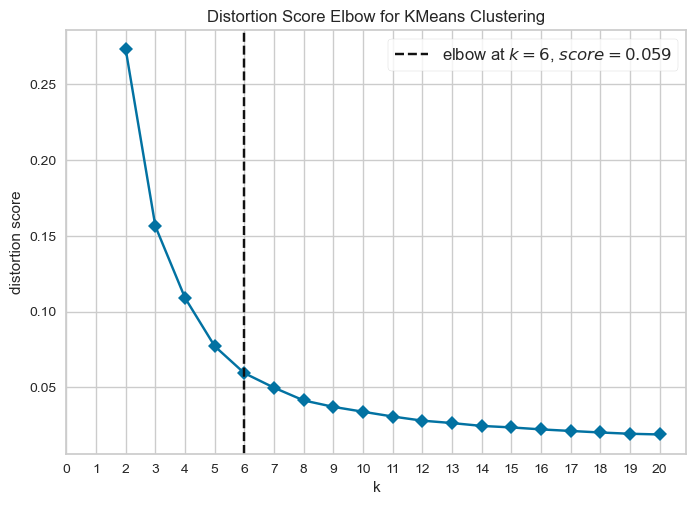

In [43]:
# Clustering for latent space data

train_latent, test_latent = determine_optimal_k(Z.cpu().detach().numpy(),
                                                Z_test.cpu().detach().numpy())

In [75]:
train_latent_df = pd.DataFrame({'id': alfred_train_ids, 'cluster': train_latent})
test_latent_df = pd.DataFrame({'id': alfred_test_ids, 'cluster': test_latent})

cluster_latent = pd.concat([train_latent_df, test_latent_df], axis=0)
cluster_latent = pd.get_dummies(cluster_latent, columns=['cluster'])
cluster_latent.to_csv('outputs/alfred_kmeans_cluster_latent_130223.csv')

Elbow value: 6


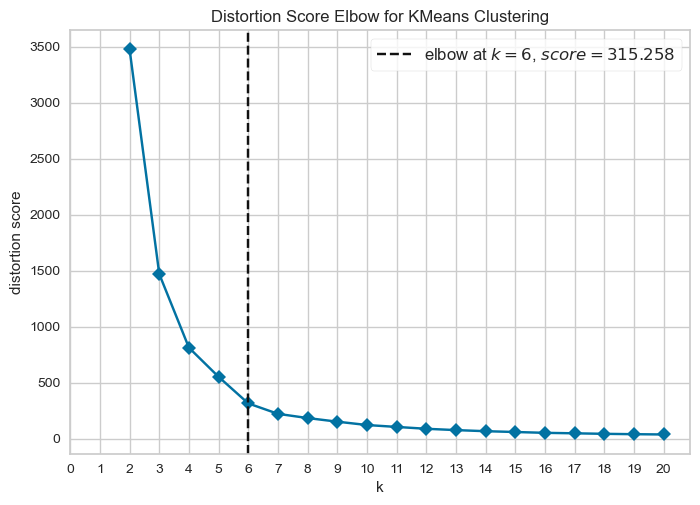

In [44]:
# Determine optimal number of clusters by elbow method UMAP-values

train_umap, test_umap = determine_optimal_k(umap_values,
                                            umap_alfred_test_values)

In [76]:
train_umap_df = pd.DataFrame({'id': alfred_train_ids, 'cluster': train_umap})
test_umap_df = pd.DataFrame({'id': alfred_test_ids, 'cluster': test_umap})

cluster_umap = pd.concat([train_umap_df, test_umap_df], axis=0)
cluster_umap = pd.get_dummies(cluster_umap, columns=['cluster'])
cluster_umap.to_csv('outputs/alfred_kmeans_cluster_umap_130223.csv')

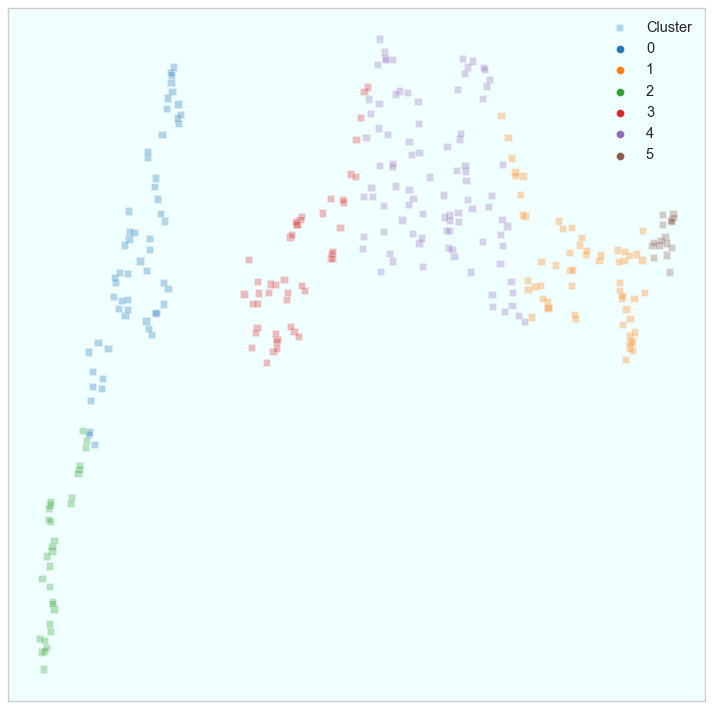

In [73]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=75)

ax = sns.scatterplot(umap_values[:,0], 
                     umap_values[:,1], 
                     marker='s',
                     hue=train_latent, 
                     palette='tab10',
                     label='Cluster',
                     alpha=0.3)

ax.set_facecolor('azure')
ax.grid(False)
ax.legend(fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [57]:
kmeans_train_ids = pd.DataFrame({"id": alfred_train_ids, 
                                 'cluster': kmeans.labels_})
kmeans_test_ids = pd.DataFrame({"id": alfred_test_ids, 
                                'cluster': test_labels})
kmean_cluster_df = pd.concat([kmeans_train_ids, kmeans_test_ids], 
                             axis=0, ignore_index=True)
ohe_cluster = pd.get_dummies(kmean_cluster_df, columns=['cluster'])


In [58]:
# Extract training data for each cluster
# for i in kmeans_train_ids['cluster'].value_counts().index:
#     tmp_df = kmeans_train_ids.copy()[kmeans_train_ids['cluster'] == i]
#     tmp_df['id'].to_csv(f"outputs/training_id_cluster_{i}.txt", header=False, index=False)



In [59]:
# kmean_cluster_df.to_csv("~/Downloads/kmeans_cluster_100223.csv", index=False)

In [60]:
previous_kmean_cluster_df = pd.read_csv("~/Downloads/cluster_info_kmeans_previous_run.csv")

In [61]:
# cluster_dict = {0: 0,
#                 1: 2,
#                 2: 1,
#                 3: 3,
#                 4: 4}

merged_kmeans_train = kmeans_train_ids.merge(previous_kmean_cluster_df,
                                             on='id',
                                             how='inner',
                                             suffixes=('_current', '_former'))

# merged_kmeans_train['mapped_cluster_former'] = merged_kmeans_train.apply(lambda row: cluster_dict[row['cluster_former']], axis=1)

In [62]:
# sum(merged_kmeans_train['cluster_current'] == merged_kmeans_train['mapped_cluster_former'])

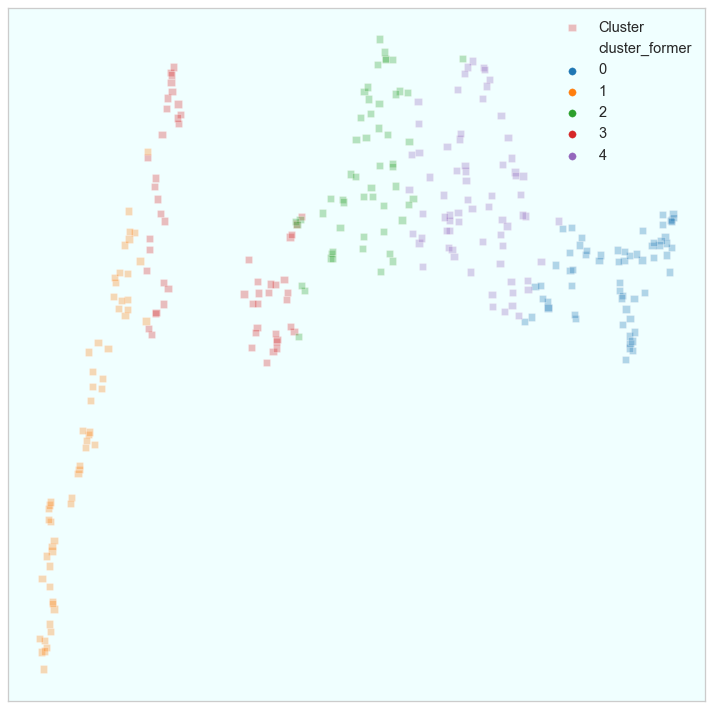

In [63]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=75)

ax = sns.scatterplot(umap_values[:,0], 
                     umap_values[:,1], 
                     marker='s',
                     hue=merged_kmeans_train['cluster_former'], 
                     palette='tab10',
                     label='Cluster',
                     alpha=0.3)

ax.set_facecolor('azure')
ax.grid(False)
ax.legend(fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

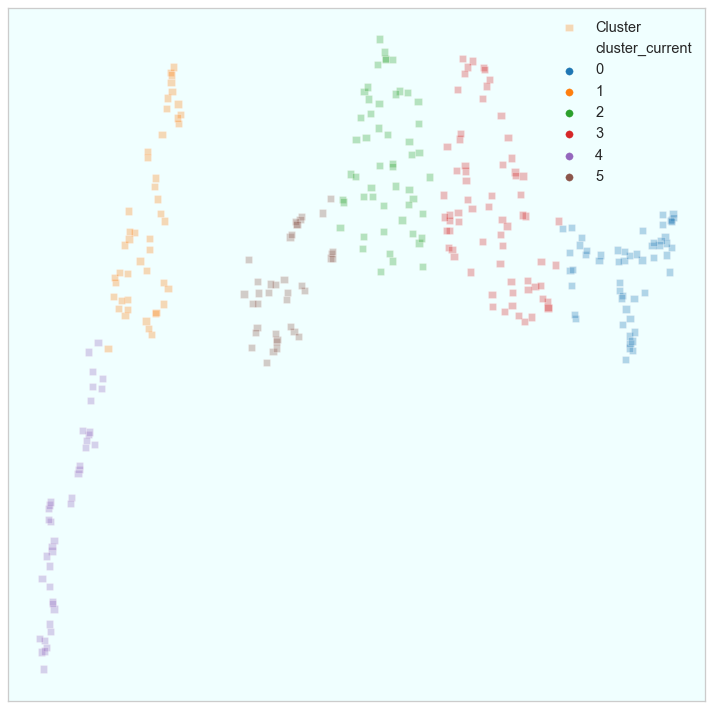

In [64]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=75)

ax = sns.scatterplot(umap_values[:,0], 
                     umap_values[:,1], 
                     marker='s',
                     hue=merged_kmeans_train['cluster_current'], 
                     palette='tab10',
                     label='Cluster',
                     alpha=0.3)

ax.set_facecolor('azure')
ax.grid(False)
ax.legend(fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.show()